# angle distance

In [116]:
import csv
import cv2
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt


observation_angles_list = [
                    (11,0,12),
                    
                    (0,11,23),
                    (0,12,24),
                    
                    (11,13,15),
                    (13,15,17),
                    
                    (12,14,16),
                    (14,16,18),
                    
                    (11,23,25),
                    (12,24,26),
                    
                    (23,25,27),
                    (24,26,28),
                    
                    (25,27,29),
                    (26,28,30)
                    
                    ]

def angle_between_points(p1, p2, p3):
    # 벡터 정의
    vec1 = np.array(p1) - np.array(p2)
    vec2 = np.array(p3) - np.array(p2)
    
    # 벡터의 내적
    dot_product = np.dot(vec1, vec2)
    
    # 벡터의 크기
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    # 코사인 값 계산
    cos_theta = dot_product / (norm1 * norm2)
    
    # 각도 계산 (라디안)
    angle_rad = np.arccos(cos_theta)
    
    # 각도 계산 (도)
    angle_deg = np.degrees(angle_rad)
    
    return angle_rad, angle_deg

def read_keypoints_from_csv(csv_file):
    keypoints = []
    world_keypoints = []
    with open(csv_file, mode='r') as file:
        reader = csv.reader(file)
        header = next(reader)
        for row in reader:
            frame_keypoints = []
            frame_world_keypoints = []
            for i in range(33):
                x = float(row[1 + i*4])
                y = float(row[2 + i*4])
                z = float(row[3 + i*4])
                visibility = float(row[4 + i*4])
                frame_keypoints.append(landmark_pb2.NormalizedLandmark(x=x, y=y, z=z, visibility=visibility))
                
                world_x = float(row[133 + i*4])
                world_y = float(row[134 + i*4])
                world_z = float(row[135 + i*4])
                world_visibility = float(row[136 + i*4])
                frame_world_keypoints.append(landmark_pb2.NormalizedLandmark(x=world_x, y=world_y, z=world_z, visibility=world_visibility))
                
            keypoints.append(frame_keypoints)
            world_keypoints.append(frame_world_keypoints)
    return keypoints, world_keypoints


def draw_landmarks(image, landmarks, color):
    mp_drawing = mp.solutions.drawing_utils
    mp_pose = mp.solutions.pose
    pose_landmarks = landmark_pb2.NormalizedLandmarkList(landmark=landmarks)
    mp_drawing.draw_landmarks(image, pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                mp_drawing.DrawingSpec(color=color, thickness=2, circle_radius=2),
                                mp_drawing.DrawingSpec(color=color, thickness=2, circle_radius=2))
    return image

def concat_images_vertically(img1, img2):
    width1, height1 = img1.size
    width2, height2 = img2.size
    new_img = Image.new('RGB', (max(width1, width2), height1 + height2))
    new_img.paste(img1, (0, 0))
    new_img.paste(img2, (0, height1))
    return new_img

def concat_images_horizontally(img_left, img_right):
    width_left, height_left = img_left.size
    width_right, height_right = img_right.size
    new_img = Image.new('RGB', (width_left + width_right, max(height_left, height_right)))
    new_img.paste(img_left, (0, 0))
    new_img.paste(img_right, (width_left, 0))
    return new_img

def draw_radar_chart(ax, data, labels, color):
    num_labels = len(labels)
    angles = [x / float(num_labels) * (2 * pi) for x in range(num_labels)]
    angles += angles[:1]
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], labels, fontsize=13)
    ax.tick_params(axis='x', which='major', pad=15)
    ax.set_rlabel_position(0)
    plt.yticks([0, 2, 4, 6, 8, 10], ['0', '2', '4', '6', '8', '10'], fontsize=10)
    plt.ylim(0, 10)
    data += data[:1]
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, data, color=color, alpha=0.4)

def draw_bar_chart(ax, data, labels, color):
    ax.bar(labels, data, color=color, alpha=0.7)
    ax.set_ylim(0, 10)
    plt.xticks(rotation=45, ha='right', fontsize=13)
    ax.set_yticks([0, 2, 4, 6, 8, 10])
    ax.set_yticklabels(['0', '2', '4', '6', '8', '10'], fontsize=10)


In [122]:
# main

trainer = 'Z52' 
user = 'Z106'

base = '317' #trainer자세 고정
trial = '313' 

shift_amount = 4

trainer_csv = f'C:/Users/jk/action_assess_2/data/output/csv_key/{trainer}/{base}-2-1-15-{trainer}_D.csv'
user_csv = f'C:/Users/jk/action_assess_2/data/output/csv_key/{user}/{trial}-2-1-15-{user}_D.csv'

trainer_key_frame_folder = f'C:/Users/jk/action_assess_2/data/output/frame_key/{trainer}/{base}-2-1-15-{trainer}_D_keypoints' 
user_key_frame_folder = f'C:/Users/jk/action_assess_2/data/output/frame_key/{user}/{trial}-2-1-15-{user}_D_keypoints' 

align_csv = f'C:/Users/jk/action_assess_2/alignment/plots/trainer_{trainer}_user_{user}/base_{base}_trial_{trial}/max_idx_list.csv'

img_right_path = 'C:/Users/jk/action_assess_2/pose_landmarks_index.png'
img_right = Image.open(img_right_path)
img_right = img_right.resize((1000, 2160))

# CSV 파일 읽기
align_df = pd.read_csv(align_csv)

keypoints_trainer, world_keypoints_trainer = read_keypoints_from_csv(trainer_csv)
keypoints_user, world_keypoints_user = read_keypoints_from_csv(user_csv)

highlight_indices = []
angle_distances_lists = []
frame_indices = []

column_names = [angle[1] for angle in observation_angles_list]

for index, row in align_df.iterrows():
    
    if index > shift_amount:
        angle_distance_list = []
        frame1_index = int(row['base']-shift_amount-1)
        frame2_index = int(row['trial']-shift_amount-1)
        print(frame1_index, '|',frame2_index)

        trainer_image_path = os.path.join(trainer_key_frame_folder, f"frame_{frame1_index:04d}.jpg")
        user_image_path = os.path.join(user_key_frame_folder, f"frame_{frame2_index:04d}.jpg")
        
        trainer_image = Image.open(trainer_image_path)
        user_image = Image.open(user_image_path)
        
        for angle in observation_angles_list:
            
            start_idx = angle[0]
            mid_idx = angle[1]
            finish_idx = angle[2]
            
            A1 = np.array([keypoints_trainer[frame1_index][start_idx].x, keypoints_trainer[frame1_index][start_idx].y])
            B1 = np.array([keypoints_trainer[frame1_index][mid_idx].x, keypoints_trainer[frame1_index][mid_idx].y])
            C1 = np.array([keypoints_trainer[frame1_index][finish_idx].x, keypoints_trainer[frame1_index][finish_idx].y])

            A2 = np.array([keypoints_user[frame2_index][start_idx].x, keypoints_user[frame2_index][start_idx].y])
            B2 = np.array([keypoints_user[frame2_index][mid_idx].x, keypoints_user[frame2_index][mid_idx].y ])
            C2 = np.array([keypoints_user[frame2_index][finish_idx].x, keypoints_user[frame2_index][finish_idx].y])
            _, angle1 = angle_between_points(A1, B1, C1)
            _, angle2 = angle_between_points(A2, B2, C2)
            
            angle_distance = round(10 - (abs(angle1-angle2)/180)*20, 1)
            
            angle_distance_list.append(angle_distance)
            
            '''if angle_distance > distance_threshold:
                highlight_indices.append(angle[1])'''
                
        angle_distances_lists.append(angle_distance_list)
        frame_indices.append(frame1_index)
        
        # Convert PIL images to OpenCV images
        trainer_image_cv2 = cv2.cvtColor(np.array(trainer_image), cv2.COLOR_RGB2BGR)
        user_image_cv2 = cv2.cvtColor(np.array(user_image), cv2.COLOR_RGB2BGR)
        
        trainer_key_image = draw_landmarks(trainer_image_cv2, keypoints_trainer[frame1_index], (0, 255, 255))
        user_key_image = draw_landmarks(user_image_cv2, keypoints_user[frame2_index], (0, 255, 0))
        
        ##################################################################
        
        fig = plt.figure(figsize=(8, 16))
        fig.set_facecolor('white')
        labels = column_names
        bar_labels = column_names

        # Create radar chart
        ax_radar = fig.add_subplot(211, polar=True)
        radar_data_values = angle_distance_list  # Use the list of angle distances
        draw_radar_chart(ax_radar, radar_data_values, labels, (1.0, 0.91, 0.0))  # Convert RGB to float

        # Create bar chart
        '''ax_bar = fig.add_subplot(212)
        bar_data_values = angle_distance_list  # Use the list of angle distances
        draw_bar_chart(ax_bar, bar_data_values, bar_labels, (1.0, 0.91, 0.0))  # Convert RGB to float'''
        
        fig.canvas.draw()
        combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        combined_chart_image = combined_chart_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        combined_chart_image = Image.fromarray(combined_chart_image)
        combined_chart_image = combined_chart_image.resize((1000, 2160))
        plt.close(fig)
        
        combined_img_right = concat_images_horizontally(combined_chart_image, img_right)
        final_concatenated_img = concat_images_horizontally(concatenated_img_vert, combined_img_right)

        ##################################################################
        
        # Save the final concatenated image
        final_concatenated_img.save(f'C:/Users/jk/action_assess_2/data/output/output/chart/final_concatenated_img_{frame1_index:04d}.jpg')

        # Convert OpenCV images back to PIL images
        trainer_key_image_pil = Image.fromarray(cv2.cvtColor(trainer_key_image, cv2.COLOR_BGR2RGB))
        user_key_image_pil = Image.fromarray(cv2.cvtColor(user_key_image, cv2.COLOR_BGR2RGB))
        
        concatenated_img_vert = concat_images_vertically(trainer_key_image_pil, user_key_image_pil)
        concatenated_img_vert_cv2 = cv2.cvtColor(np.array(concatenated_img_vert), cv2.COLOR_RGB2BGR)
        cv2.imwrite(f'C:/Users/jk/action_assess_2/data/output/output/frame_{frame1_index:04d}.jpg', concatenated_img_vert_cv2)
        
# Save angle_distances_lists to CSV
angle_distances_df = pd.DataFrame(angle_distances_lists, columns=column_names)
angle_distances_df.insert(0, 'trainer_frame', frame_indices)
angle_distances_df.to_csv('C:/Users/jk/action_assess_2/data/output/output/angle_distances.csv', index=False)

1 | 0
2 | 1


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


4 | 2
6 | 3


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


7 | 4
9 | 5
9 | 6


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


10 | 7
12 | 8
13 | 9


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


15 | 10


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


15 | 11
16 | 12


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


18 | 13


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


19 | 14


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


20 | 15


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


21 | 16
21 | 17
23 | 18


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


24 | 19
25 | 20


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


26 | 21
27 | 22


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


28 | 23
29 | 24


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


29 | 25


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


29 | 26


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\196522098.py:100: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


ValueError: 13 columns passed, passed data had 14 columns

1 | 0


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (13,) and arg 1 with shape (14,).

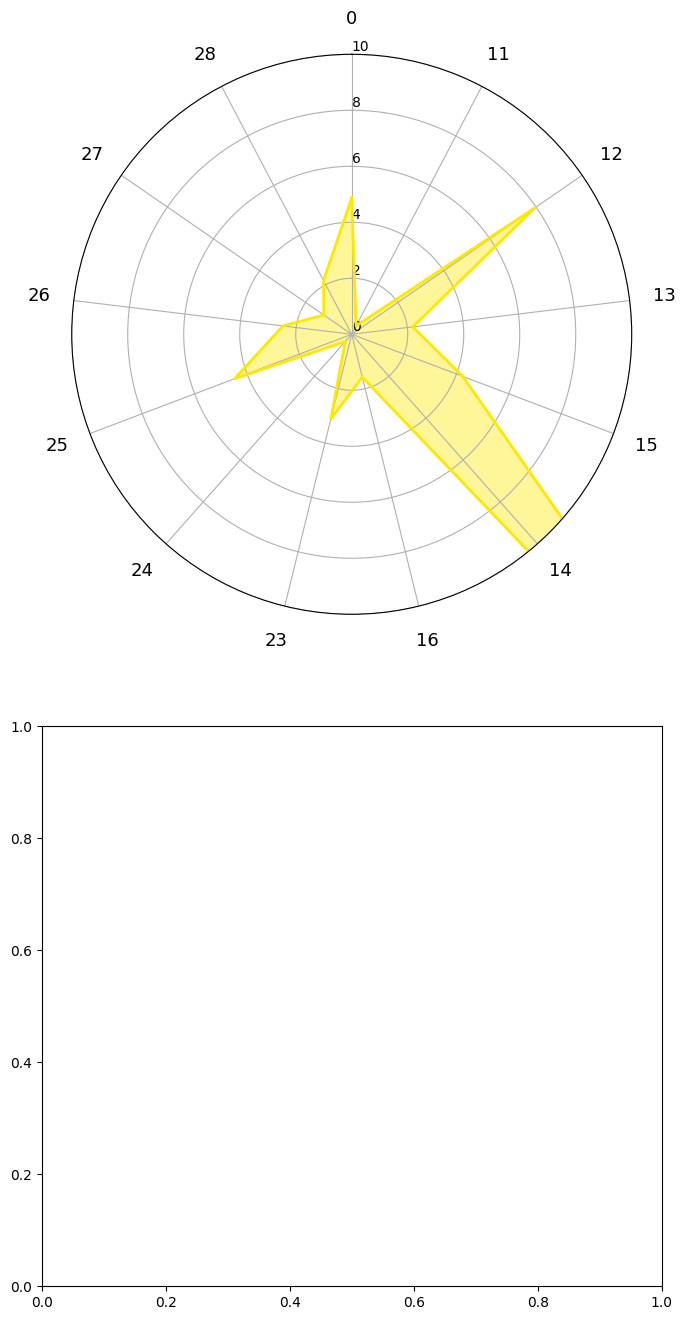

In [102]:
# main

trainer = 'Z52' 
user = 'Z106'

base = '317' #trainer자세 고정
trial = '313' 

shift_amount = 4

trainer_csv = f'C:/Users/jk/action_assess_2/data/output/csv_key/{trainer}/{base}-2-1-15-{trainer}_D.csv'
user_csv = f'C:/Users/jk/action_assess_2/data/output/csv_key/{user}/{trial}-2-1-15-{user}_D.csv'

trainer_key_frame_folder = f'C:/Users/jk/action_assess_2/data/output/frame_key/{trainer}/{base}-2-1-15-{trainer}_D_keypoints' 
user_key_frame_folder = f'C:/Users/jk/action_assess_2/data/output/frame_key/{user}/{trial}-2-1-15-{user}_D_keypoints' 

align_csv = f'C:/Users/jk/action_assess_2/alignment/plots/trainer_{trainer}_user_{user}/base_{base}_trial_{trial}/max_idx_list.csv'

img_right_path = 'C:/Users/jk/action_assess_2/pose_landmarks_index.png'
img_right = Image.open(img_right_path)
img_right = img_right.resize((1000, 2160))

# CSV 파일 읽기
align_df = pd.read_csv(align_csv)

keypoints_trainer, world_keypoints_trainer = read_keypoints_from_csv(trainer_csv)
keypoints_user, world_keypoints_user = read_keypoints_from_csv(user_csv)

highlight_indices = []
angle_distances_lists = []
frame_indices = []

column_names = [angle[1] for angle in observation_angles_list]

for index, row in align_df.iterrows():
    
    if index > shift_amount:
        angle_distance_list = []
        frame1_index = int(row['base']-shift_amount-1)
        frame2_index = int(row['trial']-shift_amount-1)
        print(frame1_index, '|',frame2_index)

        trainer_image_path = os.path.join(trainer_key_frame_folder, f"frame_{frame1_index:04d}.jpg")
        user_image_path = os.path.join(user_key_frame_folder, f"frame_{frame2_index:04d}.jpg")
        
        trainer_image = Image.open(trainer_image_path)
        user_image = Image.open(user_image_path)
        
        for angle in observation_angles_list:
            
            start_idx = angle[0]
            mid_idx = angle[1]
            finish_idx = angle[2]
            
            A1 = np.array([world_keypoints_trainer[frame1_index][start_idx].x, world_keypoints_trainer[frame1_index][start_idx].y, world_keypoints_trainer[frame1_index][start_idx].z])
            B1 = np.array([world_keypoints_trainer[frame1_index][mid_idx].x, world_keypoints_trainer[frame1_index][mid_idx].y, world_keypoints_trainer[frame1_index][mid_idx].z])
            C1 = np.array([world_keypoints_trainer[frame1_index][finish_idx].x, world_keypoints_trainer[frame1_index][finish_idx].y, world_keypoints_trainer[frame1_index][finish_idx].z])

            A2 = np.array([world_keypoints_user[frame2_index][start_idx].x, world_keypoints_user[frame2_index][start_idx].y, world_keypoints_user[frame2_index][start_idx].z])
            B2 = np.array([world_keypoints_user[frame2_index][mid_idx].x, world_keypoints_user[frame2_index][mid_idx].y, world_keypoints_user[frame2_index][mid_idx].z])
            C2 = np.array([world_keypoints_user[frame2_index][finish_idx].x, world_keypoints_user[frame2_index][finish_idx].y, world_keypoints_user[frame2_index][finish_idx].z])
            _, angle1 = angle_between_points(A1, B1, C1)
            _, angle2 = angle_between_points(A2, B2, C2)
            
            angle_distance = abs(angle1-angle2)
            angle_distance_list.append(angle_distance)
            '''if angle_distance > distance_threshold:
                highlight_indices.append(angle[1])'''
                
        angle_distances_lists.append(angle_distance_list)
        frame_indices.append(frame1_index)
        
        # Convert PIL images to OpenCV images
        trainer_image_cv2 = cv2.cvtColor(np.array(trainer_image), cv2.COLOR_RGB2BGR)
        user_image_cv2 = cv2.cvtColor(np.array(user_image), cv2.COLOR_RGB2BGR)
        
        trainer_key_image = draw_landmarks(trainer_image_cv2, keypoints_trainer[frame1_index], (0, 255, 255))
        user_key_image = draw_landmarks(user_image_cv2, keypoints_user[frame2_index], (0, 255, 0))
        
        ##################################################################
        
        fig = plt.figure(figsize=(8, 16))
        fig.set_facecolor('white')
        labels = column_names
        bar_labels = column_names

        # Create radar chart
        ax_radar = fig.add_subplot(211, polar=True)
        radar_data_values = angle_distance_list  # Use the list of angle distances
        draw_radar_chart(ax_radar, radar_data_values, labels, (1.0, 0.91, 0.0))  # Convert RGB to float

        # Create bar chart
        ax_bar = fig.add_subplot(212)
        bar_data_values = angle_distance_list  # Use the list of angle distances
        draw_bar_chart(ax_bar, bar_data_values, bar_labels, (1.0, 0.91, 0.0))  # Convert RGB to float
        
        fig.canvas.draw()
        combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        combined_chart_image = combined_chart_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        combined_chart_image = Image.fromarray(combined_chart_image)
        combined_chart_image = combined_chart_image.resize((1000, 2160))
        plt.close(fig)
        
        combined_img_right = concat_images_horizontally(combined_chart_image, img_right)
        final_concatenated_img = concat_images_horizontally(concatenated_img_vert, combined_img_right)

        ##################################################################
        
        # Save the final concatenated image
        final_concatenated_img.save(f'C:/Users/jk/action_assess_2/data/output/output/final_concatenated_img_{frame1_index:04d}.jpg')
        
        trainer_key_image_pil = Image.fromarray(cv2.cvtColor(trainer_key_image, cv2.COLOR_BGR2RGB))
        user_key_image_pil = Image.fromarray(cv2.cvtColor(user_key_image, cv2.COLOR_BGR2RGB))
        
        concatenated_img_vert = concat_images_vertically(trainer_key_image_pil, user_key_image_pil)
        concatenated_img_vert_cv2 = cv2.cvtColor(np.array(concatenated_img_vert), cv2.COLOR_RGB2BGR)
        cv2.imwrite(f'C:/Users/jk/action_assess_2/data/output/output/frame_{frame1_index:04d}.jpg', concatenated_img_vert_cv2)
        
# Save angle_distances_lists to CSV
angle_distances_df = pd.DataFrame(angle_distances_lists, columns=column_names)
angle_distances_df.insert(0, 'trainer_frame', frame_indices)
angle_distances_df.to_csv('C:/Users/jk/action_assess_2/data/output/output/angle_distances.csv', index=False)

In [ ]:
# main

trainer = 'Z52' 
user = 'Z106'

base = '317' #trainer자세 고정
trial = '313' 

shift_amount = 4

trainer_csv = f'C:/Users/jk/action_assess_2/data/output/csv_key/{trainer}/{base}-2-1-15-{trainer}_D.csv'
user_csv = f'C:/Users/jk/action_assess_2/data/output/csv_key/{user}/{trial}-2-1-15-{user}_D.csv'

trainer_key_frame_folder = f'C:/Users/jk/action_assess_2/data/output/frame_key/{trainer}/{base}-2-1-15-{trainer}_D_keypoints' 
user_key_frame_folder = f'C:/Users/jk/action_assess_2/data/output/frame_key/{user}/{trial}-2-1-15-{user}_D_keypoints' 

align_csv = f'C:/Users/jk/action_assess_2/alignment/plots/trainer_{trainer}_user_{user}/base_{base}_trial_{trial}/max_idx_list.csv'

img_right_path = 'C:/Users/jk/action_assess_2/pose_landmarks_index.png'
img_right = Image.open(img_right_path)
img_right = img_right.resize((1000, 2160))

# CSV 파일 읽기
align_df = pd.read_csv(align_csv)

keypoints_trainer, world_keypoints_trainer = read_keypoints_from_csv(trainer_csv)
keypoints_user, world_keypoints_user = read_keypoints_from_csv(user_csv)

highlight_indices = []
angle_distances_lists = []
frame_indices = []

column_names = [angle[1] for angle in observation_angles_list]

for index, row in align_df.iterrows():
    
    if index > shift_amount:
        angle_distance_list = []
        frame1_index = int(row['base']-shift_amount-1)
        frame2_index = int(row['trial']-shift_amount-1)
        print(frame1_index, '|',frame2_index)

        trainer_image_path = os.path.join(trainer_key_frame_folder, f"frame_{frame1_index:04d}.jpg")
        user_image_path = os.path.join(user_key_frame_folder, f"frame_{frame2_index:04d}.jpg")
        
        trainer_image = Image.open(trainer_image_path)
        user_image = Image.open(user_image_path)
        
        for angle in observation_angles_list:
            
            start_idx = angle[0]
            mid_idx = angle[1]
            finish_idx = angle[2]
            
            A1 = np.array([world_keypoints_trainer[frame1_index][start_idx].x, world_keypoints_trainer[frame1_index][start_idx].y, world_keypoints_trainer[frame1_index][start_idx].z])
            B1 = np.array([world_keypoints_trainer[frame1_index][mid_idx].x, world_keypoints_trainer[frame1_index][mid_idx].y, world_keypoints_trainer[frame1_index][mid_idx].z])
            C1 = np.array([world_keypoints_trainer[frame1_index][finish_idx].x, world_keypoints_trainer[frame1_index][finish_idx].y, world_keypoints_trainer[frame1_index][finish_idx].z])

            A2 = np.array([world_keypoints_user[frame2_index][start_idx].x, world_keypoints_user[frame2_index][start_idx].y, world_keypoints_user[frame2_index][start_idx].z])
            B2 = np.array([world_keypoints_user[frame2_index][mid_idx].x, world_keypoints_user[frame2_index][mid_idx].y, world_keypoints_user[frame2_index][mid_idx].z])
            C2 = np.array([world_keypoints_user[frame2_index][finish_idx].x, world_keypoints_user[frame2_index][finish_idx].y, world_keypoints_user[frame2_index][finish_idx].z])
            _, angle1 = angle_between_points(A1, B1, C1)
            _, angle2 = angle_between_points(A2, B2, C2)
            
            angle_distance = abs(angle1-angle2)
            angle_distance_list.append(angle_distance)
            '''if angle_distance > distance_threshold:
                highlight_indices.append(angle[1])'''
                
        angle_distances_lists.append(angle_distance_list)
        frame_indices.append(frame1_index)
        
        # Convert PIL images to OpenCV images
        trainer_image_cv2 = cv2.cvtColor(np.array(trainer_image), cv2.COLOR_RGB2BGR)
        user_image_cv2 = cv2.cvtColor(np.array(user_image), cv2.COLOR_RGB2BGR)
        
        trainer_key_image = draw_landmarks(trainer_image_cv2, keypoints_trainer[frame1_index], (0, 255, 255))
        user_key_image = draw_landmarks(user_image_cv2, keypoints_user[frame2_index], (0, 255, 0))
        
        ##################################################################
        '''
        fig = plt.figure(figsize=(8, 16))
        fig.set_facecolor('white')
        labels = column_names
        bar_labels = column_names

        # Create radar chart
        ax_radar = fig.add_subplot(211, polar=True)
        radar_data_values = angle_distance
        draw_radar_chart(ax_radar, radar_data_values, labels, (255,233,0))

        # Create bar chart
        ax_bar = fig.add_subplot(212)
        bar_data_values = angle_distance
        draw_bar_chart(ax_bar, bar_data_values, bar_labels,(255,233,0))
        
        fig.canvas.draw()
        combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        combined_chart_image = combined_chart_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        combined_chart_image = Image.fromarray(combined_chart_image)
        combined_chart_image = combined_chart_image.resize((1000, 2160))
        plt.close(fig)
        
        combined_img_right = concat_images_horizontally(combined_chart_image, img_right)
        final_concatenated_img = concat_images_horizontally(concatenated_img_vert, combined_img_right)
'''
        ##################################################################
        
        
        
        
        # Convert OpenCV images back to PIL images
        trainer_key_image_pil = Image.fromarray(cv2.cvtColor(trainer_key_image, cv2.COLOR_BGR2RGB))
        user_key_image_pil = Image.fromarray(cv2.cvtColor(user_key_image, cv2.COLOR_BGR2RGB))
        
        concatenated_img_vert = concat_images_vertically(trainer_key_image_pil, user_key_image_pil)
        concatenated_img_vert_cv2 = cv2.cvtColor(np.array(concatenated_img_vert), cv2.COLOR_RGB2BGR)
        cv2.imwrite(f'C:/Users/jk/action_assess_2/data/output/output/frame_{frame1_index:04d}.jpg', concatenated_img_vert_cv2)
        
# Save angle_distances_lists to CSV
angle_distances_df = pd.DataFrame(angle_distances_lists, columns=column_names)
angle_distances_df.insert(0, 'trainer_frame', frame_indices)
angle_distances_df.to_csv('C:/Users/jk/action_assess_2/data/output/output/angle_distances.csv', index=False)

1 | 0
2 | 1
4 | 2
6 | 3
7 | 4
9 | 5
9 | 6
10 | 7
12 | 8
13 | 9
15 | 10
15 | 11
16 | 12
18 | 13
19 | 14
20 | 15
21 | 16
21 | 17
23 | 18
24 | 19
25 | 20
26 | 21
27 | 22
28 | 23
29 | 24
29 | 25
29 | 26


In [89]:
column_names = [angle[1] for angle in observation_angles_list]
column_names

[0, 11, 12, 13, 15, 14, 16, 23, 24, 25, 26, 27, 28]

In [87]:
radar_data = pd.DataFrame({
    'Character': ['A', 'A', 'A', 'B', 'B', 'B'],
    'Metric1': [5, 6, 7, 4, 5, 6],
    'Metric2': [6, 7, 8, 5, 6, 7],
    'Metric3': [8, 9, 7, 6, 5, 4],
    'Metric4': [7, 3, 5, 4, 3, 2],
    'Metric5': [6, 2, 4, 3, 2, 1],
    'Metric6': [5, 4, 3, 2, 1, 3]
})

radar_data.columns[1:]

Index(['Metric1', 'Metric2', 'Metric3', 'Metric4', 'Metric5', 'Metric6'], dtype='object')

In [82]:
# Example radar data
radar_data = pd.DataFrame({
    'Character': ['A', 'A', 'A', 'B', 'B', 'B'],
    'Metric1': [5, 6, 7, 4, 5, 6],
    'Metric2': [6, 7, 8, 5, 6, 7],
    'Metric3': [8, 9, 7, 6, 5, 4],
    'Metric4': [7, 3, 5, 4, 3, 2],
    'Metric5': [6, 2, 4, 3, 2, 1],
    'Metric6': [5, 4, 3, 2, 1, 3]
})

labels = radar_data.columns[1:]
my_palette = plt.cm.get_cmap("Set2", len(radar_data.index))
print('labels',labels)
print('--'*100)
print('pallete',my_palette)

labels Index(['Metric1', 'Metric2', 'Metric3', 'Metric4', 'Metric5', 'Metric6'], dtype='object')
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
pallete <matplotlib.colors.ListedColormap object at 0x0000014FD1103910>


C:\Users\HYVision\AppData\Local\Temp\ipykernel_38812\453481615.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_palette = plt.cm.get_cmap("Set2", len(radar_data.index))


In [74]:
trainer_csv = f'C:/Users/jk/action_assess_2/data/output/csv_key/{trainer}/{base}-2-1-15-{trainer}_D.csv'
user_csv = f'C:/Users/jk/action_assess_2/data/output/csv_key/{user}/{trial}-2-1-15-{user}_D.csv'

trainer_key_frame_folder = f'C:/Users/jk/action_assess_2/data/output/frame_key/{trainer}/{base}-2-1-15-{trainer}_D_keypoints' 
user_key_frame_folder = f'C:/Users/jk/action_assess_2/data/output/frame_key/{user}/{trial}-2-1-15-{user}_D_keypoints' 

align_csv = f'C:/Users/jk/action_assess_2/alignment/plots/trainer_{trainer}_user_{user}/base_{base}_trial_{trial}/max_idx_list.csv'

# CSV 파일 읽기
align_df = pd.read_csv(align_csv)

keypoints_trainer, world_keypoints_trainer = read_keypoints_from_csv(trainer_csv)
keypoints_user, world_keypoints_user = read_keypoints_from_csv(user_csv)

np_array = np.array(world_keypoints_trainer)
print(np_array.shape)


(32, 33)


In [57]:
len(keypoints_trainer)

32

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd

def concat_images_vertically(img1, img2):
    width1, height1 = img1.size
    width2, height2 = img2.size
    new_img = Image.new('RGB', (max(width1, width2), height1 + height2))
    new_img.paste(img1, (0, 0))
    new_img.paste(img2, (0, height1))
    return new_img

def concat_images_horizontally(img_left, img_right):
    width_left, height_left = img_left.size
    width_right, height_right = img_right.size
    new_img = Image.new('RGB', (width_left + width_right, max(height_left, height_right)))
    new_img.paste(img_left, (0, 0))
    new_img.paste(img_right, (width_left, 0))
    return new_img

def draw_radar_chart(ax, data, labels, color):
    num_labels = len(labels)
    angles = [x / float(num_labels) * (2 * pi) for x in range(num_labels)]
    angles += angles[:1]
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], labels, fontsize=13)
    ax.tick_params(axis='x', which='major', pad=15)
    ax.set_rlabel_position(0)
    plt.yticks([0, 2, 4, 6, 8, 10], ['0', '2', '4', '6', '8', '10'], fontsize=10)
    plt.ylim(0, 10)
    data += data[:1]
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, data, color=color, alpha=0.4)

def draw_bar_chart(ax, data, labels, color):
    ax.bar(labels, data, color=color, alpha=0.7)
    ax.set_ylim(0, 10)
    plt.xticks(rotation=45, ha='right', fontsize=13)
    ax.set_yticks([0, 2, 4, 6, 8, 10])
    ax.set_yticklabels(['0', '2', '4', '6', '8', '10'], fontsize=10)

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd

trainer = 'Z52' 
user = 'Z106'

base = '317' #trainer자세 고정
trial = '313' 

trainer_csv = f'C:/Users/jk/action_assess_2/data/output/csv_key/{trainer}/{base}-2-1-15-{trainer}_D.csv'
user_csv =f'C:/Users/jk/action_assess_2/data/output/csv_key/{user}/{trial}-2-1-15-{user}_D.csv'

trainer_key_frame_folder = f'C:/Users/jk/action_assess_2/data/output/frame_key/{trainer}/{base}-2-1-15-{trainer}_D_keypoints' 
user_key_frame_folder = f'C:/Users/jk/action_assess_2/data/output/frame_key/{user}/{trial}-2-1-15-{user}_D_keypoints' 

align_csv = f'C:/Users/jk/action_assess_2/alignment/plots/trainer_{trainer}_user_{user}/base_{base}_trial_{trial}/max_idx_list.csv'

# CSV 파일 읽기
align_df = pd.read_csv(align_csv)

'''# 결과를 저장할 폴더
output_folder = 'C:/Users/jk/action_assess_2/alignment/plots'
os.makedirs(output_folder, exist_ok=True)'''

shift_amount = 4

# Example radar data
radar_data = pd.DataFrame({
    'Character': ['A', 'A', 'A', 'B', 'B', 'B'],
    'Metric1': [5, 6, 7, 4, 5, 6],
    'Metric2': [6, 7, 8, 5, 6, 7],
    'Metric3': [8, 9, 7, 6, 5, 4],
    'Metric4': [7, 3, 5, 4, 3, 2],
    'Metric5': [6, 2, 4, 3, 2, 1],
    'Metric6': [5, 4, 3, 2, 1, 3]
})

# Example bar chart data
bar_data = pd.DataFrame({
    'Character': ['A', 'A', 'A', 'B', 'B', 'B'],
    'Metric1': [5, 5, 6, 7, 6, 5],
    'Metric2': [4, 5, 5, 6, 6, 7],
    'Metric3': [8, 7, 6, 5, 4, 5],
    'Metric4': [3, 2, 4, 5, 6, 4],
    'Metric5': [7, 6, 5, 4, 3, 2],
    'Metric6': [4, 5, 6, 5, 4, 3]
})

labels = radar_data.columns[1:]
bar_labels = bar_data.columns[1:]
my_palette = plt.cm.get_cmap("Set2", len(radar_data.index))

# CSV 파일의 각 행에 대해 이미지 결합
for index, row in align_df.iterrows():

    if index > shift_amount:
        trainer_image_path = os.path.join(trainer_key_frame_folder, f"frame_{int(row['base']-shift_amount-1):04d}.jpg")
        user_image_path = os.path.join(user_key_frame_folder, f"frame_{int(row['trial']-shift_amount-1):04d}.jpg")

        # 이미지 읽기
        trainer_image = cv2.imread(trainer_image_path)
        user_image = cv2.imread(user_image_path)
        
        concatenated_img_vert = concat_images_vertically(trainer_image, user_image)
        fig = plt.figure(figsize=(8, 16))
        fig.set_facecolor('white')
        
        # Create radar chart
        ax_radar = fig.add_subplot(211, polar=True)
        color = my_palette(0)
        radar_data_values = radar_row.drop('Character').tolist()
        draw_radar_chart(ax_radar, radar_data_values, labels, color)

        # Create bar chart
        ax_bar = fig.add_subplot(212)
        bar_data_values = bar_row.drop('Character').tolist()
        draw_bar_chart(ax_bar, bar_data_values, bar_labels, color)
        

        
        # 결합된 이미지 저장
        output_image_path = os.path.join(output_folder, f"combined_{index}.jpg")
        cv2.imwrite(output_image_path, combined_image)




In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd

def concat_images_vertically(img1, img2):
    width1, height1 = img1.size
    width2, height2 = img2.size
    new_img = Image.new('RGB', (max(width1, width2), height1 + height2))
    new_img.paste(img1, (0, 0))
    new_img.paste(img2, (0, height1))
    return new_img

def concat_images_horizontally(img_left, img_right):
    width_left, height_left = img_left.size
    width_right, height_right = img_right.size
    new_img = Image.new('RGB', (width_left + width_right, max(height_left, height_right)))
    new_img.paste(img_left, (0, 0))
    new_img.paste(img_right, (width_left, 0))
    return new_img

def draw_radar_chart(ax, data, labels, color):
    num_labels = len(labels)
    angles = [x / float(num_labels) * (2 * pi) for x in range(num_labels)]
    angles += angles[:1]
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], labels, fontsize=13)
    ax.tick_params(axis='x', which='major', pad=15)
    ax.set_rlabel_position(0)
    plt.yticks([0, 2, 4, 6, 8, 10], ['0', '2', '4', '6', '8', '10'], fontsize=10)
    plt.ylim(0, 10)
    data += data[:1]
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, data, color=color, alpha=0.4)

def draw_bar_chart(ax, data, labels, color):
    ax.bar(labels, data, color=color, alpha=0.7)
    ax.set_ylim(0, 10)
    plt.xticks(rotation=45, ha='right', fontsize=13)
    ax.set_yticks([0, 2, 4, 6, 8, 10])
    ax.set_yticklabels(['0', '2', '4', '6', '8', '10'], fontsize=10)

def process_image_folders(folder1, folder2, output_folder, img_right_path, radar_data, bar_data):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    images1 = sorted(os.listdir(folder1))
    images2 = sorted(os.listdir(folder2))

    img_right = Image.open(img_right_path)
    img_right = img_right.resize((1000, 2160))

    labels = radar_data.columns[1:]
    bar_labels = bar_data.columns[1:]
    my_palette = plt.cm.get_cmap("Set2", len(radar_data.index))

    for img1_name, img2_name, (_, radar_row), (_, bar_row) in zip(images1, images2, radar_data.iterrows(), bar_data.iterrows()):
        try:
            img1_path = os.path.join(folder1, img1_name)
            img2_path = os.path.join(folder2, img2_name)

            img1 = Image.open(img1_path)
            img2 = Image.open(img2_path)

            concatenated_img_vert = concat_images_vertically(img1, img2)

            fig = plt.figure(figsize=(8, 16))
            fig.set_facecolor('white')

            # Create radar chart
            ax_radar = fig.add_subplot(211, polar=True)
            color = my_palette(0)
            radar_data_values = radar_row.drop('Character').tolist()
            draw_radar_chart(ax_radar, radar_data_values, labels, color)

            # Create bar chart
            ax_bar = fig.add_subplot(212)
            bar_data_values = bar_row.drop('Character').tolist()
            draw_bar_chart(ax_bar, bar_data_values, bar_labels, color)

            fig.canvas.draw()
            combined_chart_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            combined_chart_image = combined_chart_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            combined_chart_image = Image.fromarray(combined_chart_image)
            combined_chart_image = combined_chart_image.resize((1000, 2160))
            plt.close(fig)

            combined_img_right = concat_images_horizontally(combined_chart_image, img_right)
            final_concatenated_img = concat_images_horizontally(concatenated_img_vert, combined_img_right)

            output_path = os.path.join(output_folder, f"concat_{img1_name}")
            final_concatenated_img.save(output_path)
        except Exception as e:
            print(f"Error processing {img1_name} and {img2_name}: {e}")

In [ ]:


# Example usage
folder1 = 'C:/Users/jk/action_assess_2/data/output/frame_key/Z52/316-2-1-15-Z52_D_keypoints'
folder2 = 'C:/Users/jk/action_assess_2/data/output/frame_key/Z106/316-2-1-15-Z106_D_keypoints'
output_folder = 'C:/Users/jk/action_assess_2/data/output'
img_right_path = 'C:/Users/jk/action_assess_2/pose_landmarks_index.png'



################################################################
trainer = 'Z52' 
user = 'Z106'

base = '317' #trainer자세 고정
trial = '313' 

trainer_csv = f'C:/Users/jk/action_assess_2/data/output/csv_key/{trainer}/{base}-2-1-15-{trainer}_D.csv'
user_csv =f'C:/Users/jk/action_assess_2/data/output/csv_key/{user}/{trial}-2-1-15-{user}_D.csv'

trainer_key_frame_folder = f'C:/Users/jk/action_assess_2/data/output/frame_key/{trainer}/{base}-2-1-15-{trainer}_D_keypoints' 
user_key_frame_folder = f'C:/Users/jk/action_assess_2/data/output/frame_key/{user}/{trial}-2-1-15-{user}_D_keypoints' 

align_csv = f'C:/Users/jk/action_assess_2/alignment/plots/trainer_{trainer}_user_{user}/base_{base}_trial_{trial}/max_idx_list.csv'

# CSV 파일 읽기
align_df = pd.read_csv(align_csv)

################################################################




# Example radar data
radar_data = pd.DataFrame({
    'Character': ['A', 'A', 'A', 'B', 'B', 'B'],
    'Metric1': [5, 6, 7, 4, 5, 6],
    'Metric2': [6, 7, 8, 5, 6, 7],
    'Metric3': [8, 9, 7, 6, 5, 4],
    'Metric4': [7, 3, 5, 4, 3, 2],
    'Metric5': [6, 2, 4, 3, 2, 1],
    'Metric6': [5, 4, 3, 2, 1, 3]
})

# Example bar chart data
bar_data = pd.DataFrame({
    'Character': ['A', 'A', 'A', 'B', 'B', 'B'],
    'Metric1': [5, 5, 6, 7, 6, 5],
    'Metric2': [4, 5, 5, 6, 6, 7],
    'Metric3': [8, 7, 6, 5, 4, 5],
    'Metric4': [3, 2, 4, 5, 6, 4],
    'Metric5': [7, 6, 5, 4, 3, 2],
    'Metric6': [4, 5, 6, 5, 4, 3]
})

process_image_folders(folder1, folder2, output_folder, img_right_path, radar_data, bar_data)


In [3]:
# Example radar data
radar_data = pd.DataFrame({
    'Character': ['A', 'A', 'A', 'B', 'B', 'B'],
    'Metric1': [5, 6, 7, 4, 5, 6],
    'Metric2': [6, 7, 8, 5, 6, 7],
    'Metric3': [8, 9, 7, 6, 5, 4],
    'Metric4': [7, 3, 5, 4, 3, 2],
    'Metric5': [6, 2, 4, 3, 2, 1],
    'Metric6': [5, 4, 3, 2, 1, 3]
})

# Example bar chart data
bar_data = pd.DataFrame({
    'Character': ['A', 'A', 'A', 'B', 'B', 'B'],
    'Metric1': [5, 5, 6, 7, 6, 5],
    'Metric2': [4, 5, 5, 6, 6, 7],
    'Metric3': [8, 7, 6, 5, 4, 5],
    'Metric4': [3, 2, 4, 5, 6, 4],
    'Metric5': [7, 6, 5, 4, 3, 2],
    'Metric6': [4, 5, 6, 5, 4, 3]
})

for i, (char, met1, met2) in enumerate(zip(radar_data['Character'], radar_data['Metric1'], radar_data['Metric2'])):
    print(f"Character: {char}, Metric1: {met1}, Metric2: {met2}")


Character: A, Metric1: 5, Metric2: 6
Character: A, Metric1: 6, Metric2: 7
Character: A, Metric1: 7, Metric2: 8
Character: B, Metric1: 4, Metric2: 5
Character: B, Metric1: 5, Metric2: 6
Character: B, Metric1: 6, Metric2: 7
